## Entropic Relaxation of the Nested Distance

This code is adapted from the notebook available at [https://github.com/BenoitTran/END/blob/main/EntropicNestedDistance.ipynb](https://github.com/BenoitTran/END/blob/main/EntropicNestedDistance.ipynb). I have tailored it to suit my needs in order to replicate results from the paper Nested Sinkhorn Divergence to Compute the Nested Distance.

In [2]:
using JuMP, ScenTrees, LinearAlgebra, OptimalTransport, Tulip

### Packages

LinearAlgebra

JuMP https://github.com/jump-dev/JuMP.jl, for modeling optimization problems,

ScenTrees https://github.com/kirui93/ScenTrees.jl for the introduced Tree julia structure and related functions,

OptimalTransport https://github.com/zsteve/OptimalTransport.jl, to solve unregularized OT, Sinkhorn and log-domain Sinkhorn to solve regularized OT (log-domain for small regularization parameters stability). 

Tulip https://github.com/ds4dm/Tulip.jl, a primal dual interior point solver for linear optimization used by the above package.

### Nested Distance

Computing the nested distance between two trees (with the same number of time steps)

Note:
The implementation of the trees confirms that paths do not merge. However, such trees are quite restrictive:
- The values that nodes can take are bounded.
- The structure is peculiar, as every node at time t splits into the same number of child nodes.


In [93]:
using OptimalTransport
using Tulip

function nested_distance(tree1::Tree, tree2::Tree, r = 1)
    """
        Computes the Nested Distance between two given trees of the same height for parameter r = 1.
        Returns the optimal cost and associated probability plans.
    """
    T = height(tree1) + 1  # T stage (the root is at height 0)

    # Initialize cost matrix
    C = zeros(Float64, (length(nodes(tree1)), length(nodes(tree2))))

    # Dictionary to store the probability plans at each level
    probability_plans = Dict{Tuple{Int, Int}, Matrix{Float64}}()

    # Initialization: Compute cost at time T
    C[1, 1] = (abs(tree1.state[1] - tree2.state[1]))^2
    for t in 2:T
        nodes1 = nodes(tree1, t - 1)  # All nodes at stage t of tree1
        nodes2 = nodes(tree2, t - 1)
        for i in nodes1
            for j in nodes2
                C[i, j] = C[tree1.parent[i], tree2.parent[j]] + (abs(tree1.state[i] - tree2.state[j]))^2
            end
        end
    end
    C .^= (1 / 2)

    # Recursive computation: Backward in time
    for t in T - 1:-1:1
        nodes1 = nodes(tree1, t - 1)
        nodes2 = nodes(tree2, t - 1)
        for i in nodes1
            for j in nodes2
                # Retrieve children indices
                children1 = tree1.children[i + 1]
                children2 = tree2.children[j + 1]

                # Cost matrix subset for children
                cost_subset = C[children1, children2]

                # Solve the optimal transport problem
                prob_plan = zeros(Float64, length(children1), length(children2))
                emd_cost = emd2(tree1.probability[children1],
                                 tree2.probability[children2],
                                 cost_subset.^r, Tulip.Optimizer())

                # Store the probability plan for this node pair
                probability_plans[(i, j)] = prob_plan

                # Update the cost matrix
                C[i, j] = (emd_cost)^(1 / r)
            end
        end
    end

    # Return the nested distance and the probability plans
    return C[1, 1], probability_plans
end



nested_distance (generic function with 2 methods)

### Entropic Nested Distance

In [94]:
function entropic_nested_distance(tree1::Tree, tree2::Tree, max_nb_children, r, epsilon = 0 )
    """
        Computes the r-th Nested Distance between two given trees of same height for parameter r = 1 (default); 
    
        If epsilon == 0 (default value), then
        the regularization parameter gamma of the entropic wasserstein distance (Sinkhorn's algorithm)
        is adapted to the cost matrix: gamma = param_gam*100/max(cost_ij) to avoid numerical instabilities.
    
        Else if epsilon != 0, then
        compute an epsilon/T-optimal solution for each regularized OT problem, which can be done by setting
        gamma = epsilon/(4Tlog(n)) for enough iterations of Sinkhorn's algorithm. Exploits the log-sum-exp
        trick to handle small values of gamma.
    """
    if epsilon == 0 # set gamma = max(cost_ij) / 30 just to avoid numerical instabilities 
        T = height(tree1)+1; # T stage (the root is at height 0)
        C = zeros(Float64, (length(nodes(tree1)), length(nodes(tree2)))); # Alot will remain 0
        # Initialization, computes cost at time T 
        C[1,1] = (abs(tree1.state[1] - tree2.state[1]))^2;
        for t in 2:T
            nodes1 = nodes(tree1, t-1); # all nodes at stage t of tree1
            nodes2 = nodes(tree2, t-1);
            for i in nodes1
               for j in nodes2
                    C[i,j] = C[tree1.parent[i], tree2.parent[j]] + (abs(tree1.state[i] - tree2.state[j]))^2;
                end
            end
        end
        C.^=(1/2);
        # Recursive, backward in time
        for t in T-1:-1:1 
            nodes1 = nodes(tree1, t-1); 
            nodes2 = nodes(tree2, t-1);
            for i in nodes1
                for j in nodes2
                    # strange index in the children function root is implicitly numbered 0, conflict with function root() wich returns 1
                    children1 = tree1.children[i+1];
                    children2 = tree2.children[j+1];
                    gamma =  maximum(C[children1, children2]) / 10;
                    C[i,j] = (sinkhorn2(tree1.probability[children1], 
                        tree2.probability[children2], C[children1, children2].^r, gamma))^(1/r)  
                end
            end
        end
        return(C[1,1])
        else #WORK IN PROGRESS
        # epsilon > 0 and compute gamma s.t. each entropic_OT returns an epsilon/T-optimal value,
        # exploits log-sum-exp trick to handle small values of gamma.
        T = height(tree1)+1; # T stage (the root is at height 0)
        gamma = epsilon/(4*T*log(max_nb_children));
        C = zeros(Float64, (length(nodes(tree1)), length(nodes(tree2)))); 
        C[1,1] = (abs(tree1.state[1] - tree2.state[1]))^2;
        for t in 2:T
            nodes1 = nodes(tree1, t-1); 
            nodes2 = nodes(tree2, t-1);
            for i in nodes1
               for j in nodes2
                    C[i,j] = C[tree1.parent[i], tree2.parent[j]] + (abs(tree1.state[i] - tree2.state[j]))^2;
                end
            end
        end
        C.^=(1/2);
        for t in T-1:-1:1 
            nodes1 = nodes(tree1, t-1); 
            nodes2 = nodes(tree2, t-1);
            for i in nodes1
                for j in nodes2
                    children1 = tree1.children[i+1];
                    children2 = tree2.children[j+1];
                    C[i,j] = (sinkhorn2(tree1.probability[children1], 
                    tree2.probability[children2], C[children1, children2].^r, -gamma))^(1/r)  
                end
            end
        end
        return(C[1,1])
    end
end

entropic_nested_distance (generic function with 2 methods)

### Trees generation and visualization, using [Kirui, Pflug and Pichler (2020)](https://joss.theoj.org/papers/10.21105/joss.01912)

In [95]:
# Generates two trees with same depth T and random structure with a bounded number of children per node
T = 6;
max_nb_children = 5;

tree1 = Tree(vcat(1,rand(1:max_nb_children, T-1)), 1);
tree2 = Tree(vcat(1,rand(1:max_nb_children, T-1)), 1);

In [105]:
#First test, serves also as a warm up in order to run the algorithms once before the tests
a, b = nested_distance(tree1, tree2, 1)
println(entropic_nested_distance(tree1, tree2, max_nb_children, 1))
println(a)

2.946179068903506
2.717087094469782


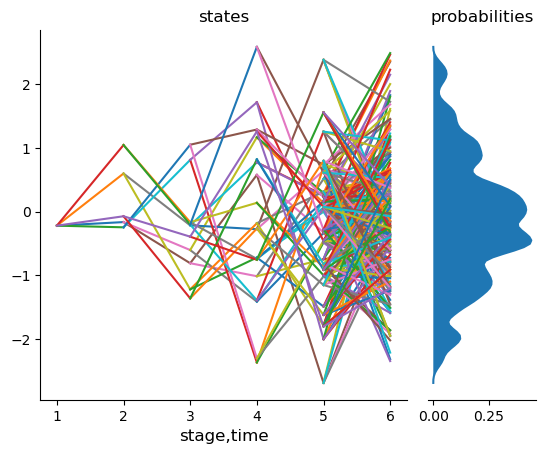

PyObject <matplotlib.collections.PolyCollection object at 0x166c13680>

In [106]:
# Plotting the first tree
tree_plot(tree1)

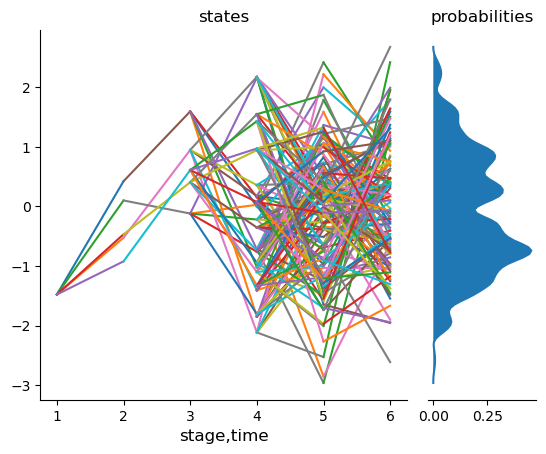

PyObject <matplotlib.collections.PolyCollection object at 0x166df92e0>

In [107]:
# Plotting the second tree
tree_plot(tree2)

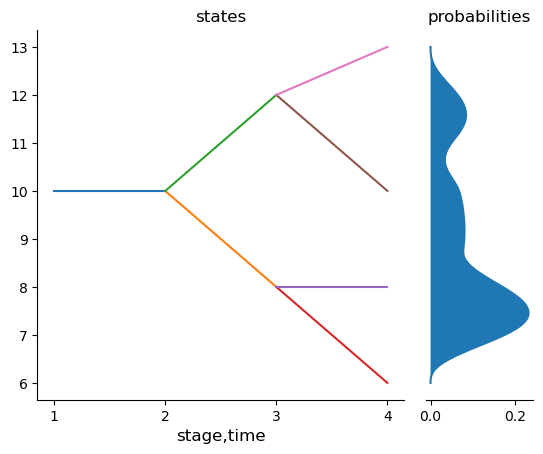

PyObject <matplotlib.collections.PolyCollection object at 0x169d69100>

In [108]:
treeExemple1 = Tree("Tree 1x1x2x2", [0,1, 2, 2, 3, 3, 4, 4], [[1], [2], [3, 4], [5, 6]], [10.0; 10.0; 8.0; 12.0; 6.0; 8.0; 10.0; 13.0;;], [1.0; 1.0; 0.66; 0.34; 0.76; 0.24; 0.46; 0.54;;])
tree_plot(treeExemple1)

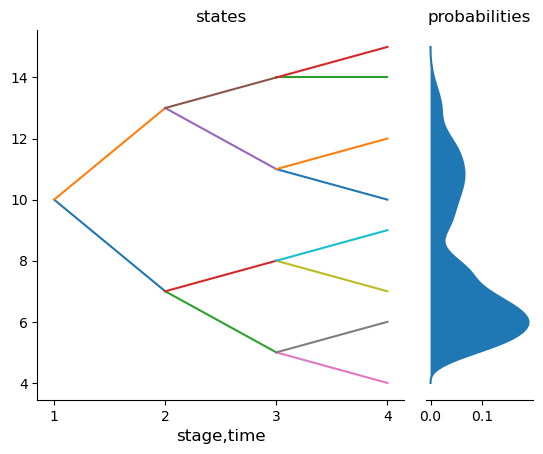

PyObject <matplotlib.collections.PolyCollection object at 0x16e81d490>

In [113]:
treeExemple2 = Tree("Tree 1x2x2x3", [0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7], [[1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [13, 14], [15, 16]], [10.0; 7.0; 13.0; 5.0; 8.0; 11.0; 14.0; 4.0; 6.0; 7.0; 9.0; 10.0; 12.0; 14.0; 15.0;;], [1.0; 0.7; 0.3; 0.9; 0.1; 0.8; 0.2; 0.7; 0.3; 0.6; 0.4; 0.4; 0.6; 0.5; 0.5;;])
tree_plot(treeExemple2)

In [116]:
# Call the nested_distance function
distance, probability_plans = nested_distance(treeExemple1, treeExemple2, 1)

# Print the nested distance
println("Nested Distance: ", distance)
# this score is different from the one I get with my own implementation
println(entropic_nested_distance(treeExemple1, treeExemple1, 3, 1))

Nested Distance: 6.025886266186437


┌ Warning: Sinkhorn algorithm (1000/1000): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/ztQxB/src/entropic/sinkhorn_solve.jl:103
┌ Warning: Sinkhorn algorithm (1000/1000): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/ztQxB/src/entropic/sinkhorn_solve.jl:103


0.0003974440033619532


┌ Warning: Sinkhorn algorithm (1000/1000): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/ztQxB/src/entropic/sinkhorn_solve.jl:103


### Computation time and absolute error of the Nested Distance and the Entropic Nested Distance

In [92]:
using Statistics

In [ ]:
# Parameters of examples with varying T and given max number of children and r
max_nb_children = 3;
Time = 2:2:10
r = 1;
itermax = 10;
# Some data to be saved
NDvsEND = zeros(Float64, length(Time));
SpeedupEND = zeros(Float64, length(Time));
tmp1 = zeros(Float64, itermax);
tmp2 = zeros(Float64, itermax);
elapsed_1 = zeros(Float64, itermax);
elapsed_2 = zeros(Float64, itermax);
ND = zeros(Float64, length(Time));
END = zeros(Float64, length(Time));
timeND = zeros(Float64, length(Time));
timeEND = zeros(Float64, length(Time));


for k in 1:length(Time)
    T = Time[k];
    println("Currently doing T = ", T)
    for iter in 1:itermax
        println("Doing iteration ", iter)
        tree1 = Tree(vcat(1,rand(1:max_nb_children, T-1)), 1);
        tree2 = Tree(vcat(1,rand(1:max_nb_children, T-1)), 1);
        start = time()
        tmp1[iter] = nested_distance(tree1, tree2, r);
        elapsed_1[iter] = time() - start
        start = time()
        tmp2[iter] = entropic_nested_distance(tree1, tree2, max_nb_children, r);
        elapsed_2[iter] = time() - start;
    end 
    ND[k] = mean(tmp1);
    END[k] = mean(tmp2);
    timeND[k] = mean(elapsed_1);
    timeEND[k] = mean(elapsed_2);
    NDvsEND[k] = mean((tmp2 - tmp1) ./ tmp1 );
    SpeedupEND[k] = mean(elapsed_1 ./ elapsed_2);
end


In [ ]:
println("Relative error ENDvsND (%) = ", NDvsEND*100)
println("Speed up of END vs ND = ", SpeedupEND)
println("timeND (ms) = ", timeND*1000)
println("timeEND (ms) = ", timeEND*1000)

In [ ]:
# Parameters of examples with varying T and given max number of children and r
max_nb_children = 3;
Time = 2:2:10
r = 2;
itermax = 10;
# Some data to be saved
NDvsEND = zeros(Float64, length(Time));
SpeedupEND = zeros(Float64, length(Time));
tmp1 = zeros(Float64, itermax);
tmp2 = zeros(Float64, itermax);
elapsed_1 = zeros(Float64, itermax);
elapsed_2 = zeros(Float64, itermax);
ND = zeros(Float64, length(Time));
END = zeros(Float64, length(Time));
timeND = zeros(Float64, length(Time));
timeEND = zeros(Float64, length(Time));


for k in 1:length(Time)
    T = Time[k];
    println("Currently doing T = ", T)
    for iter in 1:itermax
        println("Doing iteration ", iter)
        tree1 = Tree(vcat(1,rand(1:max_nb_children, T-1)), 1);
        tree2 = Tree(vcat(1,rand(1:max_nb_children, T-1)), 1);
        start = time()
        tmp1[iter] = nested_distance(tree1, tree2, r);
        elapsed_1[iter] = time() - start
        start = time()
        tmp2[iter] = entropic_nested_distance(tree1, tree2, max_nb_children, r);
        elapsed_2[iter] = time() - start;
    end 
    ND[k] = mean(tmp1);
    END[k] = mean(tmp2);
    timeND[k] = mean(elapsed_1);
    timeEND[k] = mean(elapsed_2);
    NDvsEND[k] = mean((tmp2 - tmp1) ./ tmp1 );
    SpeedupEND[k] = mean(elapsed_1 ./ elapsed_2);
end


In [ ]:
println("Relative error ENDvsND (%) = ", NDvsEND*100)
println("Speed up of END vs ND = ", SpeedupEND)
println("timeND (ms) = ", timeND*1000)
println("timeEND (ms) = ", timeEND*1000)